## Basic Holography

Before even connecting an SLM, *slmsuite*'s modular iterative holography algorithms, GPU acceleration, and ... suite ... of useful toolboxes make it a powerful tool for computational holography education, exploration, and research.   

In this first tutorial, we'll walk through the basic functionality. Specifically, we will:

- Make and visualize various target far-field patterns (spot arrays)
- Solve for the associated near-field phase masks using iterative Fourier transform (e.g. Gerchberg-Saxton or "GS") algorithms 
- Compare convergence and pattern uniformity with various flavors of GS
- Generalize these principles from spot arrays to images

We'll start by importing *slmsuite* and a few packages. Note that *slmsuite* will automatically import [*cupy*](https://cupy.dev/) for GPU acceleration if it's installed; otherwise, numpy will be used for (much slower) internal computation.

In [1]:
# TODO: delete this once the tutorial/code are stable; import via package once released
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Add slmsuite to the python path.
import sys, os
sys.path.append(os.path.join(os.getcwd(), '../../slmsuite'))

import numpy as np
import matplotlib.pyplot as plt

### Warmup: SLM Fundamentals

The simplest setup for a phase-type (e.g. LCOS) SLM places the device one focal length ($f$) in front of a thin lens to produce a desired image or pattern in the conjugate focal plane (i.e. a distance $f$ behind the lens). In this common configuration, the SLM and "image plane" are ideally related by the Fourier transform. We can therefore use *slmsuite*'s phase retrieval algorithms to solve for the unknown near-field phase pattern (that we'll eventually apply to our SLM in an experiment) that reproduces the desired far-field target in the imaging plane. Let's try it out with a simple far-field target pattern: a single pixel illuminated on a $32 \times 32$ pixel grid.

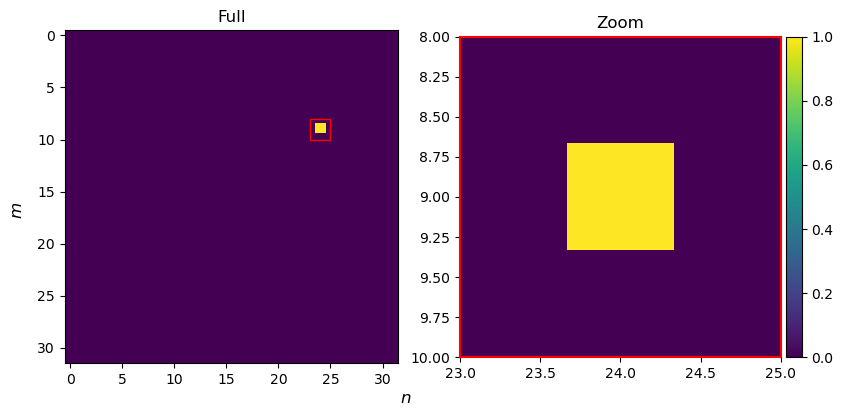

In [32]:
# Import phase retrieval algorithms
from slmsuite.holography.algorithms import Hologram

# Make the desired image: a random pixel targeted in a 32x32 grid
target_size = (32,32)
target = np.zeros(target_size)
target[9,24] = 1

# Initialize the hologram and plot the target
# Note: For now, we'll assume the SLM and target are the same size (since they're a Fourier pair)
slm_size = target_size
hologram = Hologram(target,slm_shape=slm_size)
axs,zoombox = hologram.plot_farfield(source=hologram.target, cbar=True)

In this case, we plotted the target in the basis ``"knm"`` representing the pixel indices of a detector placed in the target plane (``"knm"`` actually refers to pixels in the SLM's computational basis, but here this is aligned with camera's pixels -- the ``"ij"`` basis -- so the two are synonymous). However, since this plane and the SLM plane are a Fourier pair, each target pixel cooresponds to a 2D spatial frequency applied in the SLM plane. The exact unit conversion requires some physical properties of the SLM and camera (i.e. the detector in imaging the target). To illustrate this point, we'll instantiate simulated objects of the SLM and camera classes.

For our computations, these objects are just useful ways to store the simulated SLM and camera properties. In a real experiment, their methods will also control the hardware. 

We'll also instatiate a setup object (of the ``CameraSLM`` class) to store both the camera and SLM. In an actual experiment, the ``CameraSLM`` methods help find the relative orientation between the two devices (and more..).  

In [29]:
#Create a virtual SLM and camera
from slmsuite.hardware.slms.slm import SLM
from slmsuite.hardware.cameras.camera import Camera
from slmsuite.hardware.cameraslms import FourierSLM

# Assume a 532 nm laser
wav_um = 0.532

# Assume 10um x 10um SLM pixels and 5um x 5um camera pixels (needed for unit conversions). 
slm = SLM(slm_size[0],slm_size[1],
          dx_um=10, dy_um=10, wav_um=wav_um)

camera = Camera(target_size[0],target_size[1], 
                dx_um=5, dy_um=5, wav_um=wav_um)

# The setup (a FourierSLM setup with a camera placed in the Fourier plane of an SLM) holds the camera and SLM. 
setup = FourierSLM(camera, slm)

With these objects created, we can now re-plot the target image plane in various spatial frequency units. See the ``slmsuite.holography.toolbox.convert_blaze_vector`` function documentation for definitions of these units. 

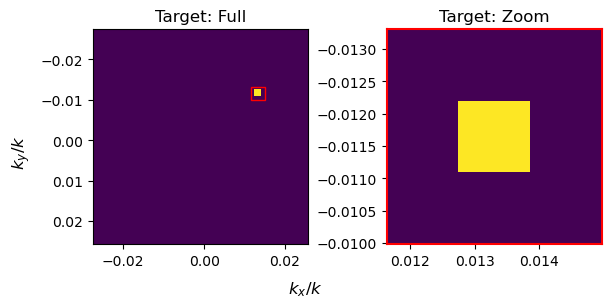

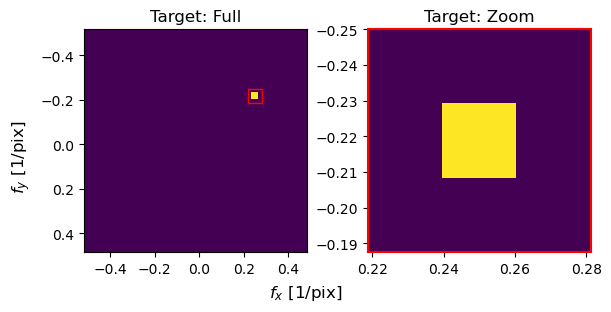

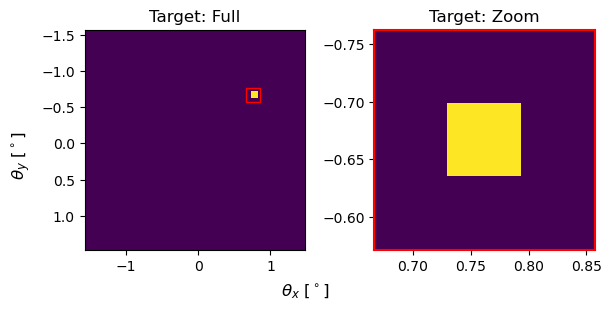

In [30]:
# Not all inclusive, but try out a few units
for units in ["kxy", "freq", "deg"]:
    hologram.plot_farfield(units=units, CameraSLM=setup, figsize=(6,3))

With a solid understanding of the near- and far-field characteristics, we can now move onto actually solving for the near-field phase mask. We'll start with the classic [Gerchberg-Saxton iterative Fourier transform algorithm](https://en.wikipedia.org/wiki/Gerchberg%E2%80%93Saxton_algorithm).

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 63.26it/s]


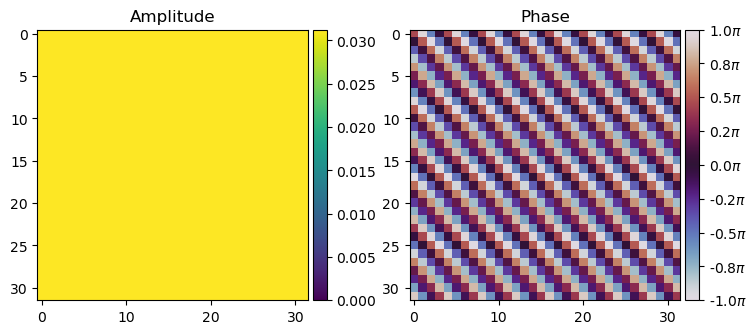

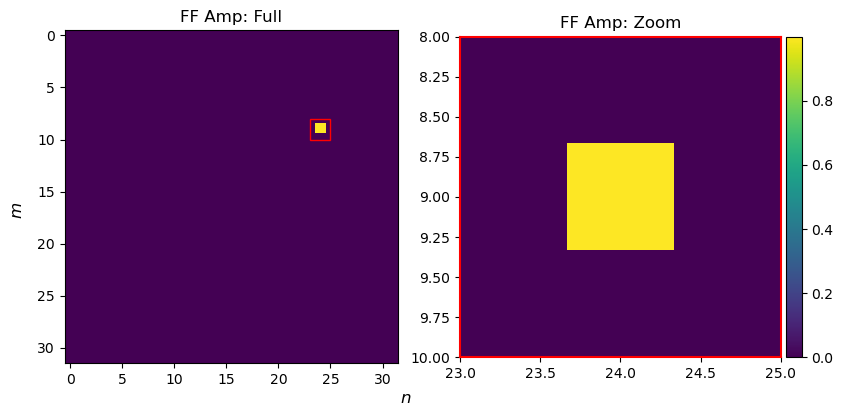

In [33]:
# 5 iterations of GS. 
hologram.optimize(method='GS', maxiter=10, stat_groups=['computational'])

# BUG! FF amp only updates w/ computation!

# Look at the associated near- and far- fields
hologram.plot_nearfield(cbar=True)
hologram.plot_farfield(source=hologram.amp_ff,limits=zoombox,cbar=True, title='FF Amp');

The near-field amplitude is unity (the SLM class assumes uniform illumination by default) and GS calculated a beautiful diagonal grating (with a ~4 pixel horizontal/vertical period as expected from the unit conversion plots above.

While at first glance it looks like the GS-computed phase mask *exactly* reproduces the desired far-field target pattern, this is actually not the case. From basic Fourier theory, we know that a uniformly illuminated aperture (comprising $N$ pixels of length $\Delta$ will emit a beamwidth $\delta k/2\pi \approx 1/N\Delta$. Sampling in increments of $\Delta$ in the near-field also corresponds to a total spatial frequency range of $1/\Delta$, which yields a bin width $1/N\Delta$ for $N$ pixels. So it only appears that we created the perfect target pattern because each pixel in the far-field corresponds to a diffraction-limited spot. 

To see the true pattern, we can increase the far-field resolution by zero-padding the near-field.

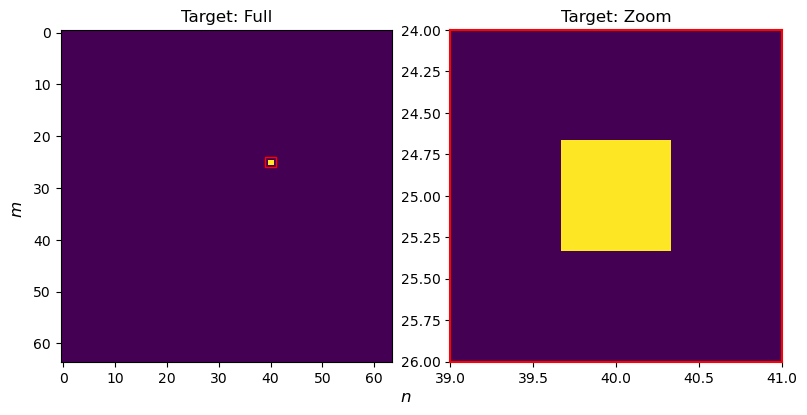

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 384.54it/s]


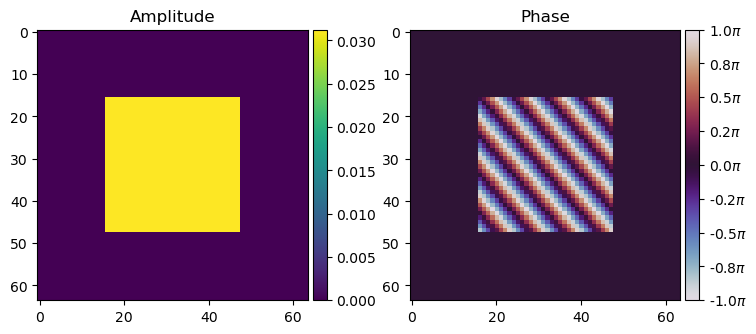

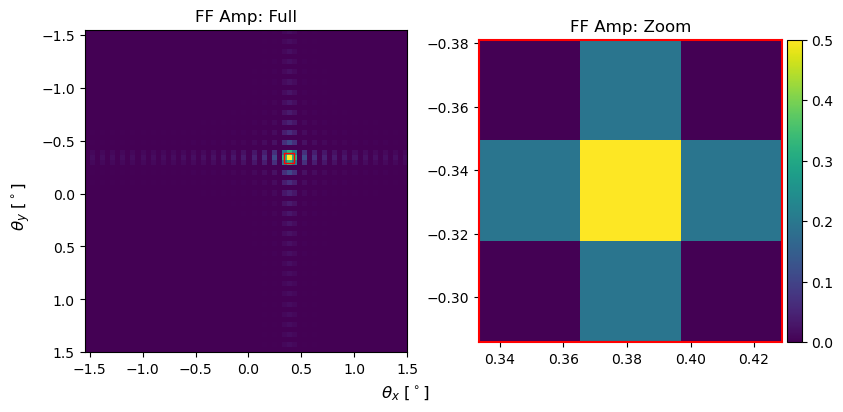

In [51]:
from slmsuite.holography import toolbox

# Get the padding needed to resolve 2x smaller than a diffraction limited spot
shape_padded = hologram.calculate_padded_shape(setup,precision=0.5/(slm.dx*slm.shape[0]))
target_padded = toolbox.pad(target, shape_padded)
_,zoombox_padded = hologram.plot_farfield()

# Recompute the far-field
hologram = Hologram(target_padded,slm_shape=slm.shape)
hologram.optimize(method='GS', maxiter=5) 

# Look at the associated near- and far- fields
hologram.plot_nearfield(padded=True,cbar=True)
hologram.plot_farfield(source=hologram.amp_ff, cbar=True, units="deg", 
                       CameraSLM=setup,title='FF Amp', limits=zoombox_padded);

# TODO: Redo this demo and keep the same spot targeted (how to scale target locs when padding?)

Likewise, far-field pixels are also smaller than diffraction limited spots when the near-field amplitude doesn't fully fill the SLM aperture as illustrated below.

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 279.37it/s]


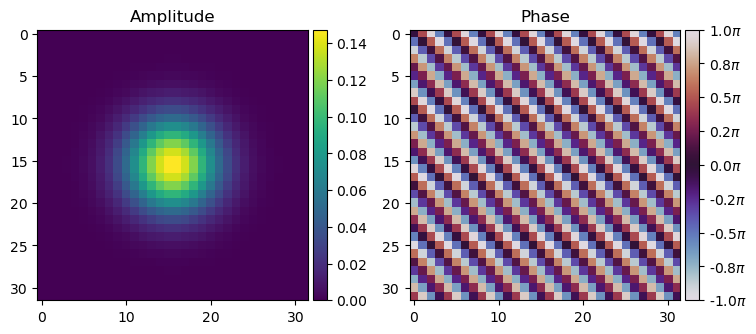

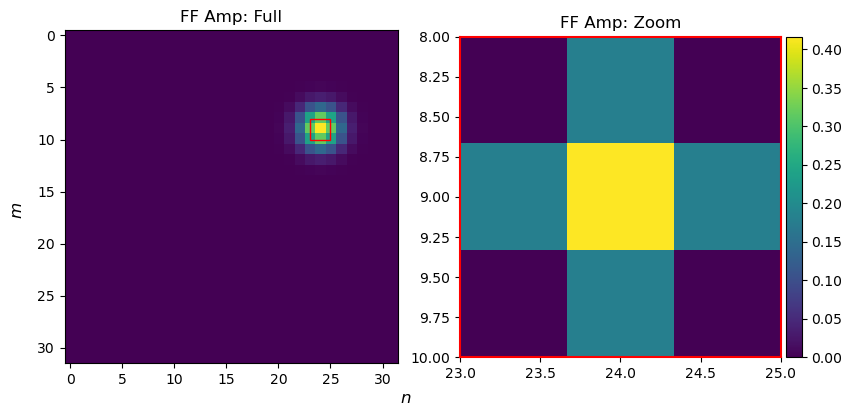

In [75]:
# TODO: add pixel # to radius here?

# Set a Gaussian amplitude profile on SLM with radius = 100 in units of x/lam
slm.set_measured_amplitude_analytic(100) 

# Redo the same GS calculations
hologram = Hologram(target,amp=slm.measured_amplitude)
hologram.optimize(method='GS', maxiter=5) 

hologram.plot_nearfield(padded=True,cbar=True)
hologram.plot_farfield(source=hologram.amp_ff, cbar=True,
                       title='FF Amp',limits=zoombox);

# TODO: should plot_farfield default to target (hence not behaving as the function name would imply)?

### Spot arrays

Now that we've discussed bare-bones GS algorithms, SLM setups, and Fourier principles, we can move onto more realistic targets. Here, for example, we'll start looking at many spots in the target plane vs a single one. 

In [416]:
slm_size = (1024,1024)
slm = SLM(slm_size[0],slm_size[1],bitdepth=32)
slm.measured_amplitude = gaussian2d(slm_grid, 0,0,1,0,slm.shape[0]/10, slm.shape[1]/10)

In [417]:
# a few spots done manually
from slmsuite.holography.algorithms import SpotHologram



In [ ]:
# many spots

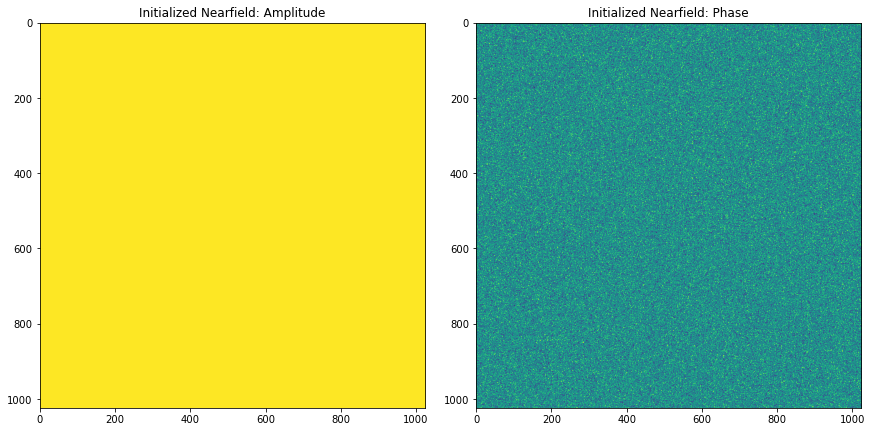

100%|██████████| 50/50 [00:10<00:00,  4.94it/s]


In [5]:
# Setup a basic spot array
shape = (1024, 1024)
array_hologram = SpotHologram.make_rectangular_array(shape,
    array_shape=(20,10), array_pitch=(5,10), basis='knm')

array_hologram.plot_nearfield(title='Initialized Nearfield')

array_hologram.optimize(method="WGS-Kim", maxiter=50, stat_groups=['computational'])

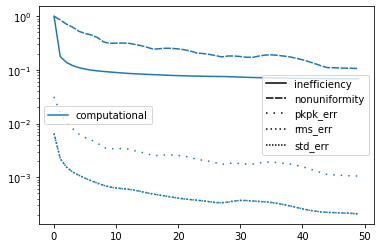

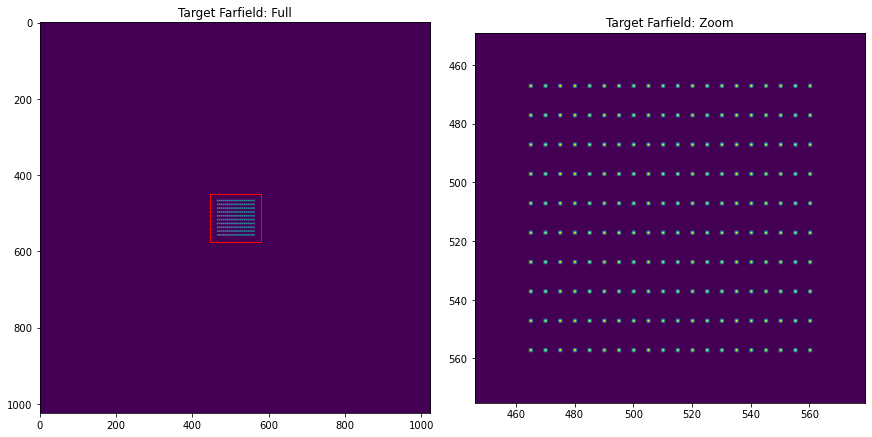

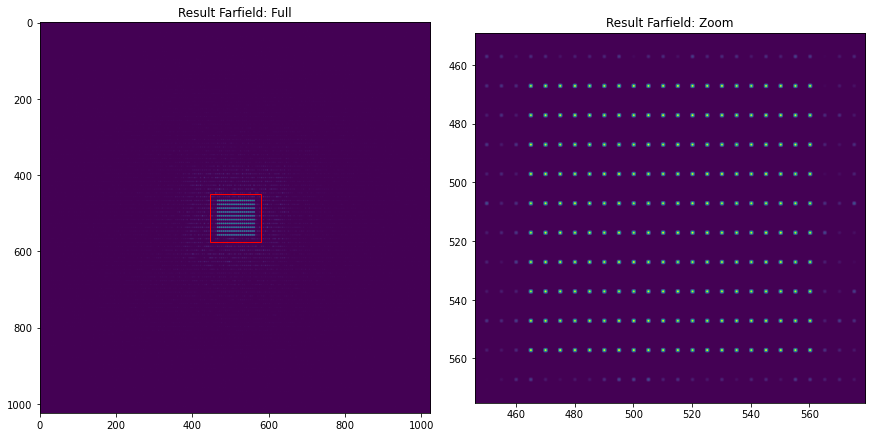

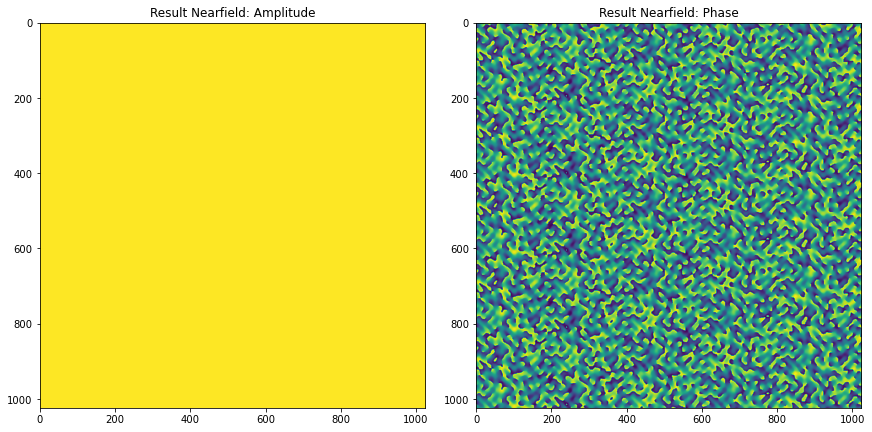

In [6]:
# Spot array plots and stats
array_hologram.plot_stats()

limits = array_hologram.plot_farfield(title='Target Farfield')
array_hologram.plot_farfield(source=array_hologram.amp_ff, 
    limits=limits, title='Result Farfield')

array_hologram.plot_nearfield(title='Result Nearfield')

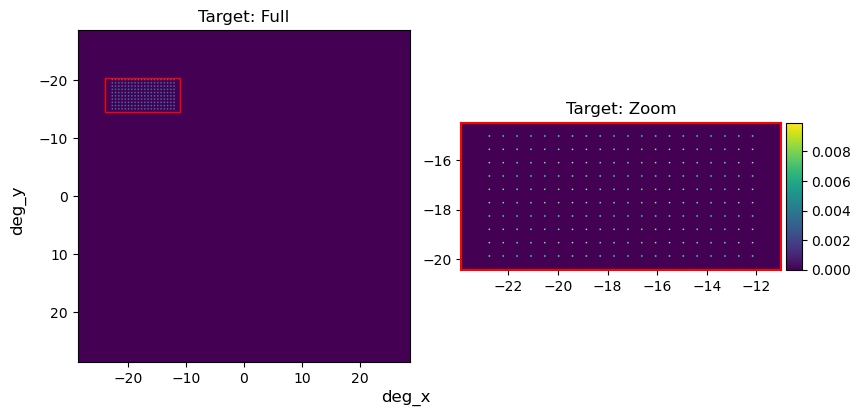

In [507]:
# Setup a basic spot array
slm_size = (1024,1024)
slm = SLM(slm_size[0],slm_size[1],bitdepth=32)
setup = CameraSLM(slm=slm,cam=None)

# TODO: rectangular target?
hologram = SpotHologram.make_rectangular_array(slm_size,
           array_shape=(20,10), array_pitch=(10,10),
           array_center=(200,200),
           basis='knm')
axs,zoom = hologram.plot_farfield(basis="deg",CameraSLM=setup,cbar=True)

# hologram.plot_nearfield(title='Initialized Nearfield')
# hologram.optimize(method="WGS-Kim", maxiter=50, stat_groups=['computational'])

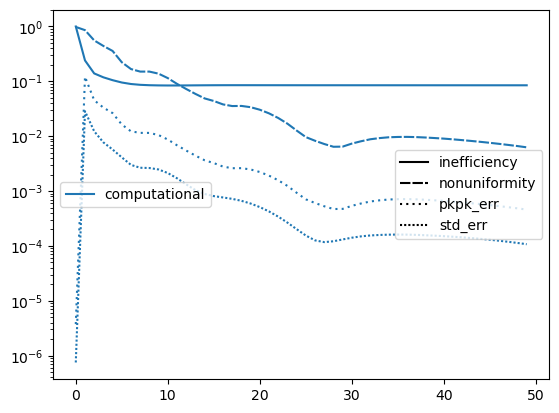

In [391]:
# statscombined = holograms["GS"].stats
# statscombined["stats"]["computational-weighted"] = \
#     holograms["WGS-Kim"].stats["stats"]["computational"]

hologram.plot_stats()


In [74]:
#notes on how spot array allows us to do unit conversion in an expt (array detection features)

#add a simulated calibaration here?

These patterns seem simple but actually incredibly useful for tweezers (nobel) optogenetics, ....

### Comparing GS Flavors

### Basic Image Formation

100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 202.20it/s]


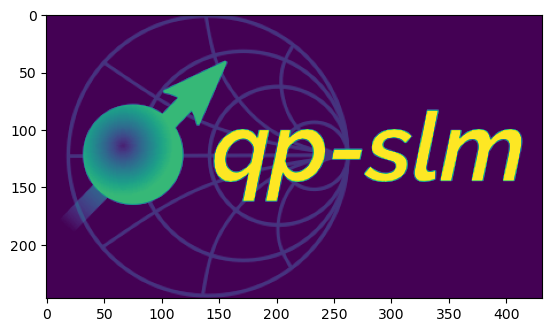

In [137]:
# Hologram creation and optimization
# Now lets try something other than spots, like a picture:
import cv2 

path = os.path.join(os.getcwd(), '../../slmsuite/docs/source/static/qp-slm-small.png')
img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

# This logo has white background, so we invert such that the field is dark.
img = cv2.bitwise_not(img)

plt.imshow(img)

# Resize (zero pad) for GS.
shape = (1024,1024)
target = lcos_toolbox.pad(img, shape)

holograms = {}

for method in ["GS", "WGS-Kim"]:
    holograms[method] = Hologram(target)
    holograms[method].optimize(method=method, maxiter=50, stat_groups=['computational'])

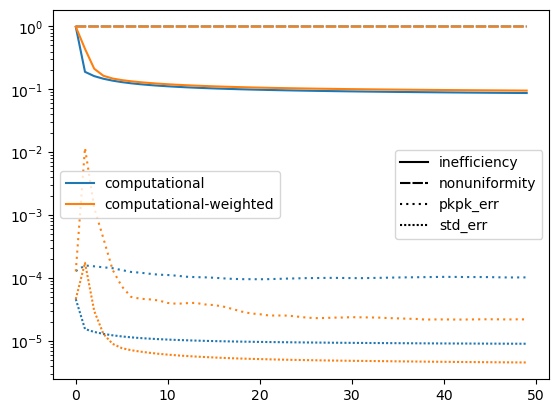

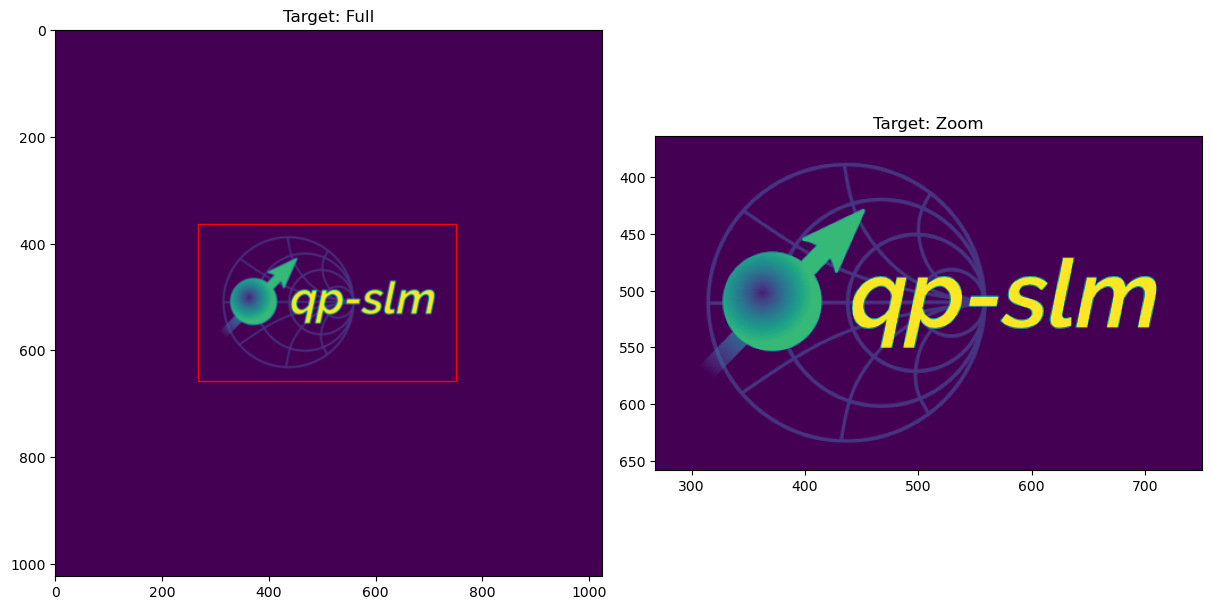

In [6]:
# Plotting
# Stats
statscombined = holograms["GS"].stats
statscombined["stats"]["computational-weighted"] = \
    holograms["WGS-Kim"].stats["stats"]["computational"]

holograms["GS"].plot_stats(statscombined)

# Farfield plots
limits = holograms["GS"].plot_farfield()

# Comparisons
for method in ["GS", "WGS-Kim"]:
    holograms[method].plot_farfield(source=holograms[method].amp_ff, 
        limits=limits, title='Result ' + method)

# for method in ["GS", "WGS-Kim"]:
#     holograms[method].plot_farfield(source=holograms[method].weights, 
#         limits=limits, title='Weights ' + method)

In [4]:
from slmsuite.holography.algorithms import SpotHologram

In [ ]:
for rot in range(4):
    for flip in range(2):
        print(rot, flip)
        transform = image_analysis.get_orientation_transformation(rot=rot, fliplr=flip, flipud=False)
        orientation = image_analysis.blob_array_detect(transform(img), [15,10], plot=True)

### Planned furture development

In [ ]:
# TODO: full simulation framework for testing new algorithms